# The Clash of the Archetypes

It's time for showdown. Let's figure out which player archetype is the best.

All the imports are centralized in the cell below.

In [2]:
import logging
from functools import partial
import random

import matplotlib.pyplot as plt

from maverick import Game, PlayerLike, PlayerState
from maverick.players import (
    TightAggressiveBot,
    LooseAggressiveBot,
    TightPassiveBot,
    LoosePassiveBot,
    ManiacBot,
    TiltedBot,
    BullyBot,
    GrinderBot,
    GTOBot,
    SharkBot,
    FishBot,
    ABCBot,
    HeroCallerBot,
    ScaredMoneyBot,
    WhaleBot,
)

# We don't want too much logging output here
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("maverick").setLevel(logging.WARNING)

In [3]:
player_types = [
    TightAggressiveBot,
    LooseAggressiveBot,
    TightPassiveBot,
    LoosePassiveBot,
    ManiacBot,
    TiltedBot,
    BullyBot,
    GrinderBot,
    GTOBot,
    SharkBot,
    FishBot,
    ABCBot,
    HeroCallerBot,
    ScaredMoneyBot,
    WhaleBot,
]

random.shuffle(player_types)
selected_player_types = player_types[:8]

In [4]:
# Function to play a game with specified parameters
def play_game(
    small_blind:int=10, 
    big_blind:int=20, 
    max_hands:int=40,
    initial_stack:int=1000
) -> tuple[list[PlayerLike],Game]:
    game = Game(small_blind=small_blind, big_blind=big_blind, max_hands=max_hands)

    players: list[PlayerLike] = []
    for i, cls in enumerate(selected_player_types):
        players.append(
            cls(
                id=f"p{i+1}",
                name=cls.__name__,
                state=PlayerState(stack=initial_stack, seat=i),
            )
        )
        game.add_player(players[-1])
        
    game.start()
    
    return players, game


# Test by playing a single game and printing the final stacks
players, game = play_game(small_blind=10, big_blind=20, max_hands=10, initial_stack=1000)
for player in players:
    print(f"{player.name} - Stack: {player.state.stack}")

TiltedBot - Stack: 7170
HeroCallerBot - Stack: 0
TightPassiveBot - Stack: 830
SharkBot - Stack: 0
ABCBot - Stack: 0
ManiacBot - Stack: 0
LoosePassiveBot - Stack: 0
GrinderBot - Stack: 0


Now play a bunch of games and visualize average payoffs. Here we define payoff as the final stock minus the initial stack. This means that the payoff can be negative. The reason behind this choice is that this gives a more intuitive visual representation (look at the FoldBot).

In [5]:
payoffs = {a.__name__ : 0 for a in player_types}
num_games = {a.__name__ : 0 for a in player_types}

In [8]:
# Start with a smaller number (like 100) to get a feel of execution time,
# then you can move to higher numbers like 10_000 for a more confident estimation.
n_games = 10_000

# Define game parameters
small_blind = 10
big_blind = 20
max_hands = 10         
initial_stack = 1000

# Create helper function with fixed parameters
play = partial(
    play_game, 
    small_blind=small_blind, 
    big_blind=big_blind, 
    max_hands=max_hands,
    initial_stack=initial_stack
)

for _ in range(n_games):
    # Rotate the selected player types
    random.shuffle(player_types)
    selected_player_types = player_types[:8]
    
    # Play a game
    players, game = play()
    
    # Collect payoffs
    for player in players:
        payoffs[player.__class__.__name__] += player.state.stack - initial_stack
        num_games[player.__class__.__name__] += 1

# Compute average payoffs    
average_payoffs = {name: payoffs[name]/num_games[name] for name in payoffs}

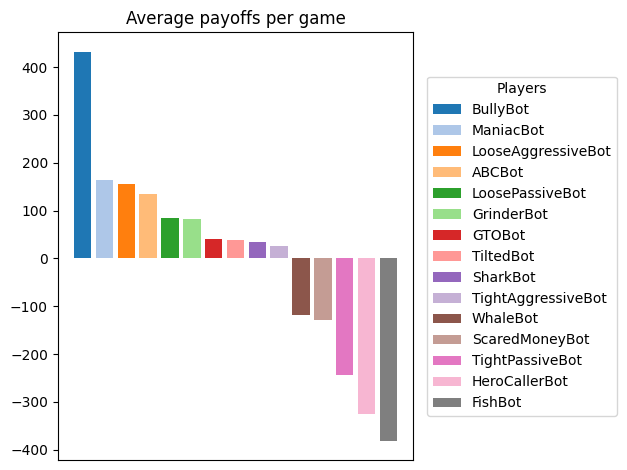

In [9]:
fig, ax = plt.subplots()

# Sort by payoff (descending)
sorted_items = sorted(average_payoffs.items(), key=lambda kv: kv[1], reverse=True)

names = [name for name, _ in sorted_items]
avg_payoffs = [payoff for _, payoff in sorted_items]

cmap = plt.get_cmap("tab20")
for i, (player_name, payoff) in enumerate(zip(names, avg_payoffs)):
    ax.bar(player_name, payoff, color=cmap(i % cmap.N), label=player_name)

ax.set_title("Average payoffs per game")
ax.legend(
    title="Players",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
)

# Remove x-axis labels (tick labels)
ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

plt.tight_layout()
plt.show()